# Objective

* Predict power usage of a day ("Value (kWh)")
* Use dataset from https://www.kaggle.com/srinuti/residential-power-usage-3years-data-timeseries
* The data has been prepared in the "DataPreparation.ipynb" notebook
* Again, the purpose of this exercise is more to get more familiar with PyTorchLightning and LSTMs than getting the perfect prediction

# Setup

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers.csv_logs import CSVLogger

# Create a Dataset

In [9]:
class PowUseDataset(Dataset):
    
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len
    
    def __len__(self):
        return self.X.__len__() - (self.seq_len - 1)
        
    def __getitem__(self, idx):
        return (self.X[idx:idx+self.seq_len-1], self.y[idx+self.seq_len-1])

# Create a Data Module

In [10]:
class PowUsageDataModule(pl.LightningDataModule):
    
    def __init__(self, seq_len, batch_size, num_workers):
        super().__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def setup(self, stage):
        
        # read data
        df_total = pd.read_csv('data/df_total.csv')
        
        # define  X and y
        columns = ['Temp_max','Temp_avg','Temp_min','Dew_max','Dew_avg','Dew_min','Hum_max','Hum_avg','Hum_min','Wind_max','Wind_avg','Wind_min','Press_max','Press_avg','Press_min','Precipit','day_of_week_pow']
        
        X  = df_total[columns].values
        
        y = df_total['Value (kWh)'].values
        
        # split data
        self.X_test, X_tmp, self.y_test, y_tmp = train_test_split(X, y, test_size=.2)
        self.X_val, self.X_train, self.y_val, self.y_train = train_test_split(X_tmp, y_tmp, test_size=.25)
        
        # reshape labels
        self.y_train = self.y_train.reshape(-1,1)
        self.y_val = self.y_val.reshape(-1,1)
        self.y_test = self.y_test.reshape(-1,1)
        
        # normalize data
        scaler = StandardScaler()
        scaler.fit(self.X_train)
        scaler.transform(self.X_train)
        scaler.transform(self.X_val)
        scaler.transform(self.X_test)
        
        minmax = MinMaxScaler()
        minmax.fit(self.y_train)
        minmax.transform(self.y_train)
        minmax.transform(self.y_val)
        minmax.transform(self.y_test)
        
        
    def train_dataloader(self):
        
        # create dataset
        train_dataset = PowUseDataset(self.X_train, self.y_train, seq_len=self.seq_len)
        
        # wrap in dataloader
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False, 
                                      num_workers=self.num_workers)
        return train_dataloader
        
    def val_dataloader(self):
        
        # create dataset
        val_dataset = PowUseDataset(self.X_val, self.y_val, seq_len=self.seq_len)
        
        # wrap in dataloader 
        val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False,
                                   num_workers=self.num_workers)
        return val_dataloader
        
    def test_dataloader(self):
        
        # create dataset
        test_dataset = PowUseDataset(self.X_test, self.y_test, seq_len=self.seq_len)
        
        # wrap in dataloader 
        test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False,
                                   num_workers=self.num_workers)
        return test_dataloader


# Create a Model

In [11]:
class PowUsageModel(pl.LightningModule):

    def __init__(self, input_size, learning_rate,
                hidden_size, num_layers, dropout, 
                criterion):
        super().__init__()
        
        self.train_losses = []
        self.train_losses_epoch = []
        self.val_losses = []
        self.val_losses_epoch = []
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.criterion = criterion
        
        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            dropout=self.dropout,
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        
        x, _ = self.lstm(x) # x=(batch_size, seq_len, hidden_size)
        x = self.fc(x[:,-1])
         
        return x
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.train_losses.append(loss.item())
        self.log('train_loss', loss, prog_bar=True)
        log = {'train_loss': loss}
        return {'loss': loss, 'log': log}
        #return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.val_losses.append(loss.item())
        self.log('val_loss', loss)
        log = {'val_loss': loss}
        return {'val_loss': loss, 'log': log}
        
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        log = {'test_loss': loss}
        return {'loss': loss, 'log': log}
        
        
    def validation_epoch_end(self, logits):
        val_loss_epoch = torch.stack([x['val_loss'] for x in logits]).mean()
        self.log('val_loss_epoch', val_loss_epoch)

# Callbacks

In [12]:
class CustomCallbacks(Callback):
    
    def on_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        print(f"Epoch {epoch}: {metrics}")


# Set Paramteters

In [13]:
p = {'seq_len': 10,
     'batch_size': 64,
     'num_workers': 8,
     'max_epochs': 50,
     'learning_rate': 0.001,
     'input_size': 17,
     'hidden_size': 10,
     'num_layers': 1, 
     'dropout': .2, 
     'criterion': nn.MSELoss()}

# Train

In [15]:
csv_logger = CSVLogger('./', name='lstm', version='0'),

data_module = PowUsageDataModule(seq_len=p['seq_len'], batch_size=p['batch_size'], 
                                 num_workers=p['num_workers'])

model = PowUsageModel(input_size=p['input_size'], learning_rate=p['learning_rate'], 
                      hidden_size=p['hidden_size'], num_layers=p['num_layers'], dropout=p['dropout'], 
                      criterion=p['criterion'])

early_stop_callback = EarlyStopping(monitor='val_loss_epoch',
                                        min_delta=0.00,
                                        patience=10,
                                        verbose=False,
                                        mode='min')

trainer = pl.Trainer(callbacks=[early_stop_callback, CustomCallbacks()], max_epochs=p['max_epochs'], logger=csv_logger)
trainer.fit(model, data_module)

/home/frauke/anaconda3/envs/lightning_env/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
/home/frauke/anaconda3/envs/lightning_env/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Experiment logs directory ./lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 1.2 K 
2 | fc        | Linear  | 11    
--------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params


Epoch 0:   0%|          | 0/6 [00:00<?, ?it/s] 

/home/frauke/anaconda3/envs/lightning_env/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


Epoch 0:  33%|███▎      | 2/6 [00:00<00:00, 19.52it/s, loss=2, v_num=0, train_loss=2.3]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 6/6 [00:00<00:00, 15.94it/s, loss=2, v_num=0, train_loss=1.71]
                                                         Epoch 0: {'loss': tensor(1.7070), 'train_loss': tensor(1.7070), 'val_loss': tensor(2.0318), 'val_loss_epoch': tensor(1.9883)}
Epoch 1:  33%|███▎      | 2/6 [00:00<00:00, 17.68it/s, loss=1.87, v_num=0, train_loss=2.07]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 22.04it/s, loss=1.87, v_num=0, train_loss=1.41]
                                                         Epoch 1: {'loss': tensor(1.4108), 'train_loss': tensor(1.4108), 'val_loss': tensor(1.8664), 'val_loss_epoch': tensor(1.8306)}
Epoch 2: 100%|██████████| 6/6 [00:00<00:00, 24.46it/s, loss=1.74, v_num=0, train_loss=1.16]
                              Epoch 2: {'loss': tensor(1.1617), 'train_loss': tensor(1.1617), 'val_loss': tensor(1.7025

Epoch 21: 100%|██████████| 6/6 [00:00<00:00, 20.22it/s, loss=0.667, v_num=0, train_loss=0.364]
                              Epoch 21: {'loss': tensor(0.3642), 'train_loss': tensor(0.3642), 'val_loss': tensor(0.6073), 'val_loss_epoch': tensor(0.5913)}
Epoch 22:  50%|█████     | 3/6 [00:00<00:00, 22.88it/s, loss=0.635, v_num=0, train_loss=0.616]
Validating: 0it [00:00, ?it/s]
Epoch 22: 100%|██████████| 6/6 [00:00<00:00, 18.90it/s, loss=0.635, v_num=0, train_loss=0.347]
                                                         Epoch 22: {'loss': tensor(0.3469), 'train_loss': tensor(0.3469), 'val_loss': tensor(0.5831), 'val_loss_epoch': tensor(0.5673)}
Epoch 23: 100%|██████████| 6/6 [00:00<00:00, 22.35it/s, loss=0.603, v_num=0, train_loss=0.332]
                              Epoch 23: {'loss': tensor(0.3321), 'train_loss': tensor(0.3321), 'val_loss': tensor(0.5691), 'val_loss_epoch': tensor(0.5534)}
Epoch 24: 100%|██████████| 6/6 [00:00<00:00, 23.03it/s, loss=0.574, v_num=0, train_loss=0.3

Epoch 41: 100%|██████████| 6/6 [00:00<00:00, 18.19it/s, loss=0.379, v_num=0, train_loss=0.246]
                                                         Epoch 41: {'loss': tensor(0.2462), 'train_loss': tensor(0.2462), 'val_loss': tensor(0.4720), 'val_loss_epoch': tensor(0.4562)}
Epoch 42: 100%|██████████| 6/6 [00:00<00:00, 24.23it/s, loss=0.375, v_num=0, train_loss=0.244]
                              Epoch 42: {'loss': tensor(0.2436), 'train_loss': tensor(0.2436), 'val_loss': tensor(0.4680), 'val_loss_epoch': tensor(0.4522)}
Epoch 43:  50%|█████     | 3/6 [00:00<00:00, 17.74it/s, loss=0.371, v_num=0, train_loss=0.469]
Validating: 0it [00:00, ?it/s]
Epoch 43: 100%|██████████| 6/6 [00:00<00:00, 17.81it/s, loss=0.371, v_num=0, train_loss=0.241]
                                                         Epoch 43: {'loss': tensor(0.2410), 'train_loss': tensor(0.2410), 'val_loss': tensor(0.4641), 'val_loss_epoch': tensor(0.4483)}
Epoch 44:  50%|█████     | 3/6 [00:00<00:00, 23.62it/s, loss=0.3

1

# Evaluation

In [16]:
metrics = pd.read_csv('./lstm/0/metrics.csv')
metrics.head()

,val_loss,val_loss_epoch,epoch,step,train_loss
0,2.031821,1.988346,0.0,1,NaN
1,1.866373,1.830570,1.0,3,NaN
2,1.702493,1.676819,2.0,5,NaN
3,1.572041,1.550434,3.0,7,NaN
4,1.481326,1.462491,4.0,9,NaN


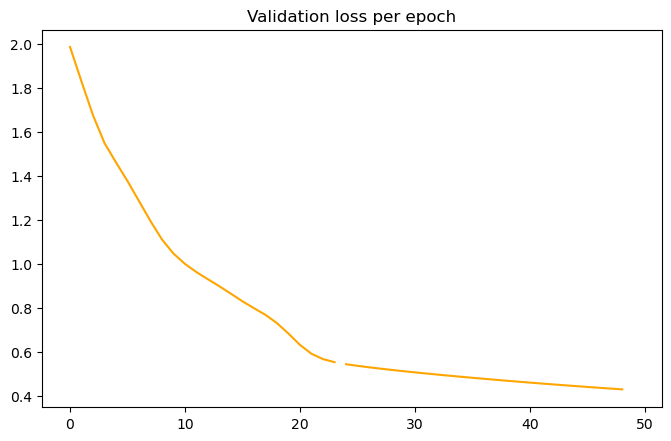

MSE:
Val loss:   0.426


In [17]:
val_loss = metrics[['val_loss_epoch', 'epoch']]

fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi=100)
#axes[0].set_title('Train loss per batch')
#axes[0].plot(train_loss['step'], train_loss['train_loss'])
axes.set_title('Validation loss per epoch')
axes.plot(val_loss['epoch'], val_loss['val_loss_epoch'], color='orange')
plt.show(block = True)

print('MSE:')
#print(f"Train loss: {train_loss['train_loss'].iloc[-1]:.3f}")
print(f"Val loss:   {val_loss['val_loss_epoch'].iloc[-1]:.3f}")
#print(f'Test loss:  {test_loss:.3f}')